In [1]:
from sklearn.datasets import fetch_mldata
import matplotlib
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

mnist = fetch_mldata("MNIST original")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape
# 对于每个手写体28×28=784 

((70000, 784), (70000,))

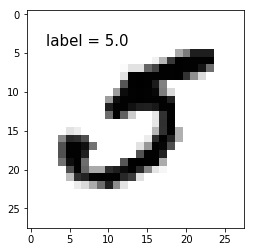

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28) # 还原成二位维矩阵
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, 
           interpolation='nearest')
# plt.axis("off")
plt.text(2, 4, "label = {}".format(y[36001]), size = 15) 
plt.show()

In [5]:
sp = 60000
X_train, X_test, y_train, y_test = X[:sp], X[sp:], y[:sp], y[sp:]

In [6]:
import numpy as np

shuffle_index = np.random.permutation(sp)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 二分类器
从一个判断手写体是否是5简单二分类出发

In [7]:
# 调整数据的label为2class
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42,max_iter=100, tol=None)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

### 性能评估

#### 手动完成交叉验证

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train  [train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold   = X_train  [test_index ]
    y_test_fold   = y_train_5[test_index ]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.96785
0.9548
0.9629


In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96785, 0.9548 , 0.9629 ])

#### 看起来预测出是5的准确性很高，但是注意我们评估的方法是拿 预测对的除以总数
下面看一个*非5*二分器表现

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9078 , 0.9093 , 0.91185])

可想而知我们都预测是false正确率也有90%, 原因在于只有一小部分正例，引入其他评估方法

### 混淆矩阵
对于矩阵元素$(i,j)$ 表示$i$被识别称$j$的数量

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # cross_val_predict输出具体预测的结果

In [15]:
y_train_pred

array([ True,  True, False, ..., False, False, False])

### 通过比较y_train_5和y_train_pred计算混淆矩阵

In [16]:
from sklearn.metrics import confusion_matrix

_confusion_matrix = confusion_matrix(y_train_5, y_train_pred) # confusion_matrix(真实label, 预测)

In [17]:
_confusion_matrix

array([[54247,   332],
       [ 1957,  3464]])

$(0,0)=54055$ 非$5$被识别成非$5$ 真反例 $true\ positives  $  
$(0,1)=524$  非$5$被识别成5   假反例 $false\ positives  $  
$(1,0)=1449$  $5$被识别成非$5$ 假反例 $false\ negatives  $  
$(1,1)=3972$  $5$被识别成$5$   真正例 $true\ positives  $  


#### 更简洁的测度

1. 正例的精确度，考量的范围不再是全体样本
$\displaystyle precosion = \frac{TP}{TP+FP}$  
做一次正例的判断保证预测正确的概率  
2. 被分类器正确预测为正例的比例  $\displaystyle recall = \frac{TP}{TP+FN}$  
$\begin{bmatrix} TN & FP \\ FN & TP\end{bmatrix}$

### Precision and Recall

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(_confusion_matrix[1][1] / (_confusion_matrix[1][1] + _confusion_matrix[0][1]))

0.9125395152792413
0.9125395152792413


In [19]:
print(recall_score(y_train_5, y_train_pred))
print(_confusion_matrix[1][1] / (_confusion_matrix[1][1] + _confusion_matrix[1][0]))

0.6389964951116031
0.6389964951116031


$F_1$量度定义为准确和查全率的调和平均数
$\displaystyle F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2 \times \frac{precision \times recall}{precision + recall}$

In [20]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.751654551372464

$F_1$量度综合考虑了准确度和查全率，但往往我们需要给他们分配权重，在不同的项目中，我们有自己的偏好。  
但实情是当我们提高一方面会削减另一个方面。这称为$precision/recall\ tradeoff$

分类器为其预测基于$decision\ function$打分，如果分数高于阈值归为正例，反之亦然。  
选取不同的$decision\ threshold$会影响$precision$和$recall$得分    
一般而言提高阈值随之提高了准确率，降低了召回率，反之，降低准确率，提高召回率。  
sklearn不提供直接修改阈值，但我们可以通过调节`descision_function()`达到目的

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3981.37772237])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")  # 输出具体的得分
y_scores

array([ 14344.87633729,   7567.82140676, -22506.58001148, ...,
       -15625.04015326, -56374.90287504, -22612.94742342])

基于以上的得分我们可以调整阈值达到不同的准确率和查全率

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 
# 预测结果,交叉验证得分来 得到在不同阈值设置下查全率和查准率

In [26]:
# 对于不同的阈值，绘制precisions和recalls曲线
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 查准率
    plt.plot(thresholds, recalls[:-1],"g--", label="Recall", linewidth=2) # 查全率
    plt.xlabel("Threshold", fontsize=16)
    plt.ylim([0, 1])
    plt.legend(loc="upper left", fontsize=16)

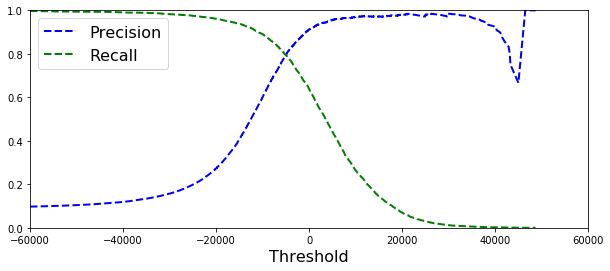

In [27]:
plt.figure(figsize=(10, 4))
plt.xlim([-60000, 60000])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [28]:
#### 试试直接绘制precision vs recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1])
    #  plt.axis([0, 1, 0, 1]) # 合并为一句

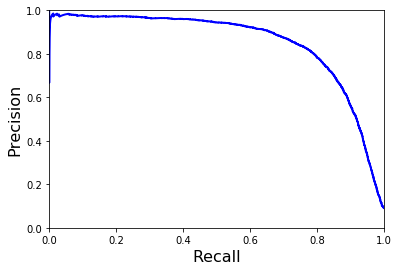

In [29]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [30]:
y_train_pred_90 = (y_scores > 5000)
precision_score(y_train_5, y_train_pred_90)

0.9553962564715253

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4425382770706512

#### ROC曲线  
$receiver\ operating\ characteristic\ curve$   
反应模型的泛化能力，绘制$TPR\ against\ FPR$   
$\displaystyle TPR(true\ positive\ rate) = \frac{TP}{TP+FN}$  , $\displaystyle FPR(false\ positive\ rate) = \frac{FP}{FP+TN}$   


In [32]:
from sklearn.metrics import roc_curve

fpr, tpr ,thresholds = roc_curve(y_train_5, y_scores)

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

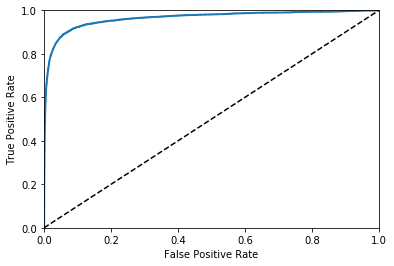

In [34]:
plot_roc_curve(fpr, tpr) # 绘制ROC
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score # 计算AUC ROC 面积
roc_auc_score(y_train_5, y_scores)

0.9642974532846397

#### 何时使用ROC与PR
当正例很少或者我们关心$FP$超过$FN$时选用PR curve   
想想
反之选择ROC curve

随机森林分类器
注意其工作方式并没与`decision_function()`显示分数，其使用`dict_proba()`方法    
对于sklearn的分类器都有其中一种可以显示估计器得分的方法  

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [37]:
y_proba_forest # 输出两个 label

array([[0. , 1. ],
       [0.7, 0.3],
       [0.9, 0.1],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

### Multiclass Classification
多类别分类器
随机森林，朴素贝叶斯分类器等都能直接处理多类别，其他的例如支持向量机和线性模型是严格二分类器   
然而仍有方法去实现线性模型个多分类。  

一种称为$(one-versus-all)OvA$, 对手写体做十个二分类器组合预测       
从每个分类器得到该图像的`decision score`取得分最高作为预测结果   
另一种称为(`one-versus-one`)$OvO$ ，对每对数字做一个分类器,共计需要$\displaystyle\frac{N*(N-1)}{2}$个分类器    
预测时从这些分类器中查询结果，这种策略的好处在于每个分类器只需在部分训练数据上跑模型。  
对于有些算法例如支持向量机分类器在大数据下表现不优，此时就可以采取OvO方式训练出很多小模型。   
对于大部分机器学习算法优先采用OvA方式  

In [38]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [39]:
sgd_clf.predict([some_digit]) # sklearn 对于y_train多class 自动OvA多类分类(除了SVM)

array([5.])

In [40]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [41]:
some_digit_scores # 实际上sklearn 底下训练了10组分类器

array([[ -8767.1583592 , -28434.23639605, -15375.96926209,
        -15053.8624407 , -26689.81636005,   3981.37772237,
        -43076.93474333, -25584.21102096, -29794.24807625,
        -31170.63859883]])

In [42]:
np.argmax(some_digit_scores)

5

In [43]:
sgd_clf.classes_ # 按序存储class

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [44]:
sgd_clf.classes_[5]

5.0

强制使用$OvO$跑线性多分类器   
从`OneVsOneClassifier` 或 `OneVsRestClassifier` 类自己构造即可

In [45]:
import warnings 
warnings.filterwarnings('ignore') # 强用ovo会报Further Warning这里忽略下！

from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([5.])

In [46]:
len(ovo_clf.estimators_) # 10 * 9 / 2 = 45

45

In [47]:
# 随机森林并没有使用ovo or ova，其可以直接多分类
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [48]:
forest_clf.predict_proba([some_digit])

array([[0.3, 0. , 0. , 0.1, 0. , 0.6, 0. , 0. , 0. , 0. ]])

In [49]:
forest_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# array([0.87567487, 0.86234312, 0.87038056])

array([0.87747451, 0.87954398, 0.88413262])

尝试特征缩放 优化

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [52]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# array([0.91261748, 0.91069553, 0.91113667])

array([0.91276745, 0.91219561, 0.91293694])

### 分析错误

假设我们有了几个较好的模型，现在来分析其错误是什么造成的

In [53]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [54]:
y_train_pred # 返回预测结果score 返回预测得分

array([5., 5., 0., ..., 9., 2., 1.])

In [55]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [56]:
conf_mx
# 主对角线位为正确的预测

array([[5694,    1,   16,    8,   11,   50,   44,    6,   88,    5],
       [   1, 6462,   45,   27,    5,   43,    4,   11,  129,   15],
       [  39,   33, 5341,   99,   77,   26,   76,   46,  208,   13],
       [  38,   30,  132, 5360,    2,  222,   29,   50,  179,   89],
       [  17,   19,   44,   13, 5343,    8,   50,   28,  121,  199],
       [  46,   27,   37,  185,   60, 4622,   91,   23,  240,   90],
       [  30,   23,   45,    2,   45,   94, 5599,    7,   72,    1],
       [  23,   15,   71,   30,   50,    9,    4, 5795,   37,  231],
       [  30,   94,   52,  116,    6,  128,   43,   14, 5281,   87],
       [  29,   28,   30,   83,  146,   38,    2,  192,  140, 5261]])

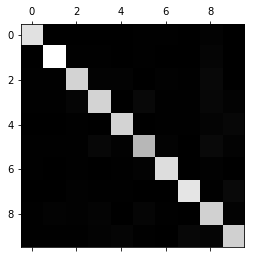

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [58]:
#### 使用错误率而非绝对错误的数量描述图像
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

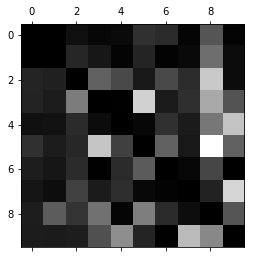

In [59]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

行为实际的class，列为预测的class   
观察错误来源$(8, *), (*, 8), (5, 3), (3, 5), (7, 9), (9, 7)$  
通过混淆矩阵帮我们后期优化致命方向，应该改善8,9与其他数字的区别，调整3,5的预测方式

个体分析3,5

In [60]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

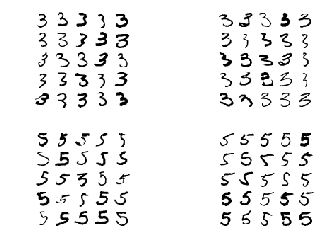

In [61]:
cl_a, cl_b = 3, 5
# 手工混淆矩阵
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# 默认子图命令是subplot(111)
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [62]:
# 左侧为预测为a=3, 右侧为预测为b=5

### Multilabel Classification 多标签分类器

单标签分类器把训练数据扔进一个class中，多标签分类器对任务要扔到多个class中

In [63]:
y_train_large = (y_train >= 7)
y_train_odd =(y_train % 2 == 1)
y_multiabel = np.c_[y_train_large, y_train_odd]

In [64]:
print("y_train_large: ", y_train_large)
print("y_train_odd: ", y_train_odd)
print("y_multiabel: \n", y_multiabel)

y_train_large:  [False False  True ...  True False False]
y_train_odd:  [ True  True False ...  True False  True]
y_multiabel: 
 [[False  True]
 [False  True]
 [ True False]
 ...
 [ True  True]
 [False False]
 [False  True]]


In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multiabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
knn_clf.predict([some_digit]) # some_digit = 5

array([[False,  True]])

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [73]:
import pickle
with open("../y_train_knn_pred.pk", "rb") as f:
     y_train_knn_pred = pickle.load(f)

In [74]:
f1_score(y_train, y_train_knn_pred, average="macro") # average=macro label同等重要， weighted加权

0.09778545692602647

In [75]:
import pickle

with open('../y_train_knn_pred.pk', 'wb') as f:
#     np.ndarray.dump(y_train_knn_pred, f)
     pickle.dump(y_train_knn_pred, f)

### Multioutput Classifiction 多输出分类器

#### 模拟一个系统输入混乱的图片输出干净的图片

In [76]:
### 产生噪声

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [77]:
def plot_digit(data):
    image = data.reshape(28, 28) # 别忘了reshape成(28*28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

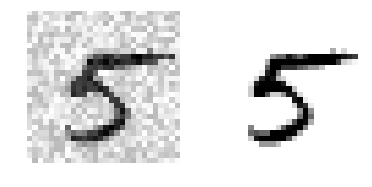

In [78]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

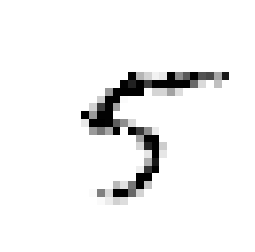

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

### Extra material

#### 伪分类器 提供基线参考

In [80]:
from sklearn.dummy import DummyClassifier # 随机分类器
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:,1]

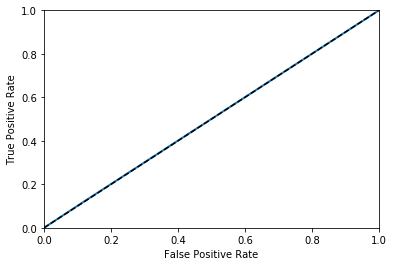

In [81]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifie

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1, weights="distance", n_neighbors=4)
knn_clf.fit(X_train, y_train)

## Exercises

### 1. Knn超参优化
knn在此类问题山表现优秀，尝试用网格搜索做超参优化  
knn分类器的主要超参：weights和n_neighbors

### 2. 数据增强 data augmentation
尝试对原有手写体进行旋转，增强/扩充数据集

In [ ]:
from scipy.ndimage.interpolation import shift

def shift_image(img, dx, dy):
    img = img.reshape(28, 28)
    shifted_image = shift(img, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image_set = X_train[233]
print(y_train[233])
shifted_image_down = shift_image(image_set, dx=0, dy=5)
shifted_image_left = shift_image(image_set, dx=-5, dy=0)

plt.figure(figsize=(5,3))

plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image_set.reshape(28,28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [img for img in X_train]
y_train_augmented = [img for img in y_train]

In [ ]:
for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx=dx, dy=dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)